<img src = 'https://naked-science.ru/wp-content/uploads/2016/04/article_Fotolia_42679861_M.jpg'>

## <center> Прогнозирование оттока клиентов банка

## Постановка задачи

Банк хочет разработать кампанию лояльности по удержанию клиентов. Для этого ему необходимо прогнозировать вероятности оттока клиентов и определять, уйдёт ли клиент в ближайшее время. 

**Задача в рамках Data Science** - построить классификатор, который позволит своевременно определять уходящих клиентов банка, оценить качество построенных моделей и проинтерпретировать результаты.

Разделим эту задачу на две части:
* В первой части мы подготовим данные для моделирования и построим простейшую модель логистической регрессии, оценим её качество и проанализируем результаты её работы.
* Во второй части мы займёмся построением моделей дерева решений и случайного леса, сравним их результаты с результатами, полученными на первом этапе, и сделаем финальный вывод.

Для начала импортируем библиотеки, которые нам понадобятся:

In [81]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации
import plotly.express as px

from sklearn import linear_model #линейные модели
from sklearn import metrics #метрики
from sklearn import model_selection #сплитование выборки
from sklearn import preprocessing #предобработка данных
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

Прочитаем нашу таблицу:

In [82]:
churn_data = pd.read_csv('churn.csv')
churn_data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## Разведывательный анализ данных

Отобразим соотношение ушедших и лояльных клиентов.

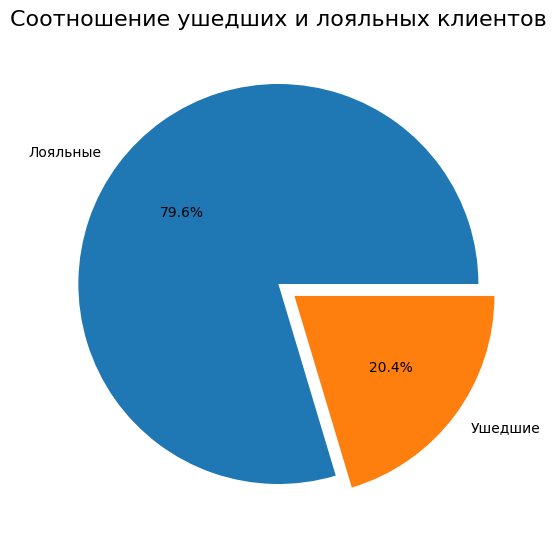

In [83]:
ch_data = churn_data.copy() # Копируем базу данных, чтобы случайно не повредить её

loyality = ch_data['Exited'].value_counts() # Создаём признак по ушедшим и лояльным клиентам
fig = plt.figure(figsize=(10, 5))
axes = fig.add_axes([0, 0, 1, 1])
axes.pie( # Для отображения соотношения выбираем круговую диаграмму
    loyality,
    labels=['Лояльные', 'Ушедшие'],
    autopct='%.1f%%',
    explode=[0, 0.1]
)
axes.set_title('Соотношение ушедших и лояльных клиентов', fontsize = 16);

Посмотрим на баланс клиентов в разрезе оттока.

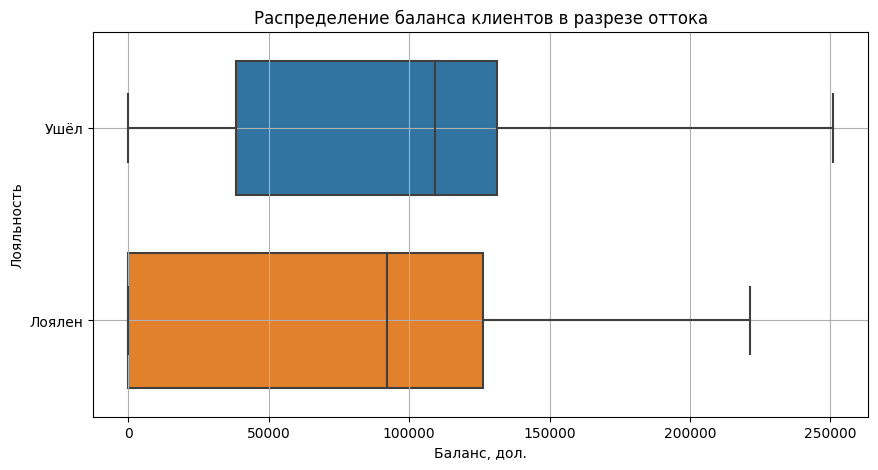

In [84]:
# Для более понятного отображения данных введём новый признак Status,
# который будет указывать лояльность клиента не в непонятных цифрах,
# а напрямую словами "Лоялен и "Ушёл"
def get_status(status): # Создаём функцию, определяющую статус клиента
    if status == 0:
        if_loyal = 'Лоялен'
    else:
        if_loyal = 'Ушёл'
    return if_loyal
if_stay = ch_data['Exited'].apply(get_status) # Распространяем функцию на таблицу
ch_data['Status'] = if_stay # Вводим в таблицу новый столбец

fig = plt.figure(figsize=(10, 5))
ch_data_balance = sns.boxplot( # Для решения поставленной задачи построим коробчатую диаграмму
    data=ch_data,
    x='Balance',
    y='Status',
    orient='h',
    width=0.7
)
ch_data_balance.set_title('Распределение баланса клиентов в разрезе оттока')
ch_data_balance.set_xlabel('Баланс, дол.')
ch_data_balance.set_ylabel('Лояльность')
ch_data_balance.grid()

Сравним возраст ушедших и лояльных клиентов.

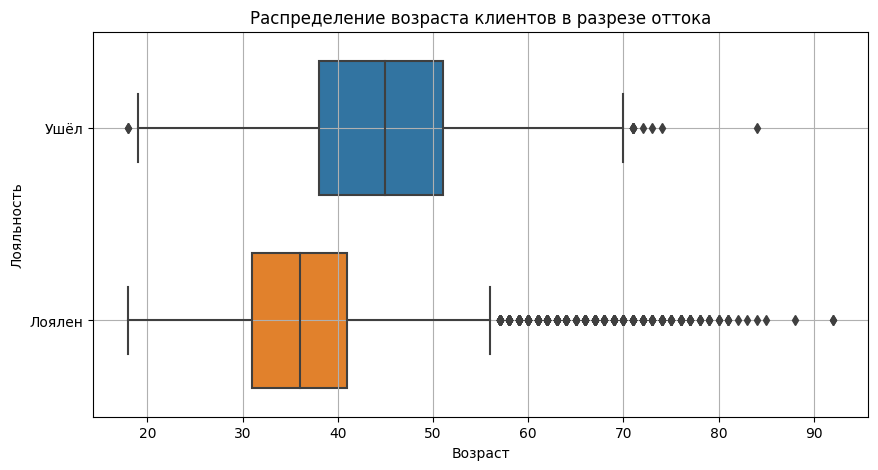

In [89]:
fig = plt.figure(figsize=(10, 5))
ch_data_age = sns.boxplot( # Для решения поставленной задачи построим коробчатую диаграмму
    data=ch_data,
    x='Age',
    y='Status',
    orient='h',
    width=0.7
)
ch_data_age.set_title('Распределение возраста клиентов в разрезе оттока')
ch_data_age.set_xlabel('Возраст')
ch_data_age.set_ylabel('Лояльность')
ch_data_age.grid()

Сравним взаимосвязь кредитного рейтинга и предполагаемой зарплаты у ушедших и лояльных клиентов.

In [90]:
fig = px.scatter( # построим диаграмму рассеяния
    data_frame=ch_data, 
    x = 'EstimatedSalary', 
    y = 'CreditScore', 
    color='Status', 
    width=1000,
    height=700,
    title = 'Взаимосвязь кредитного рейтинга и предполагаемой зарплаты',
)
fig.show()

Как распределяются ушедшие клиенты в зависимости от пола.

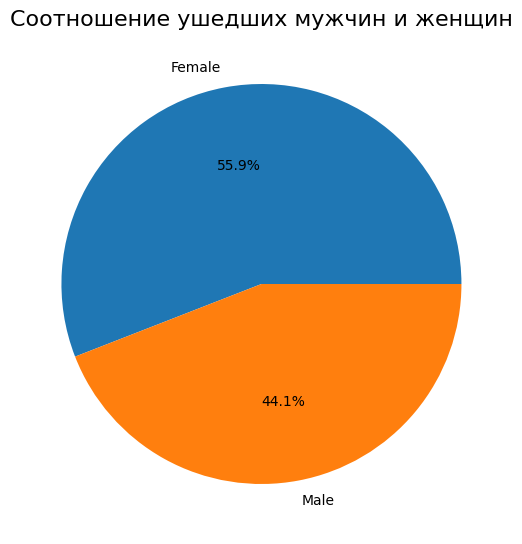

In [91]:
ch_data_exited = ch_data[ch_data['Exited'] == 1]
gender = ch_data_exited['Gender'].value_counts() # Создаём признак по ушедшим и лояльным клиентам
fig = plt.figure(figsize=(10, 5))
axes = fig.add_axes([0, 0, 1, 1])
axes.pie( # Для отображения соотношения выбираем круговую диаграмму
    gender,
    labels = gender.index,
    autopct='%.1f%%'    
)
axes.set_title('Соотношение ушедших мужчин и женщин', fontsize = 16);

Распределение баланса на счетах ушедших мужчин и женщин выглядит так.

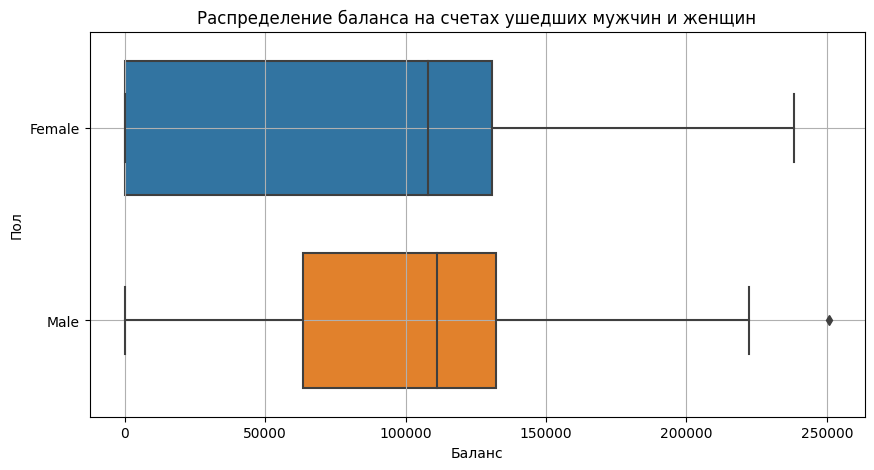

In [92]:
fig = plt.figure(figsize=(10, 5))
balance_exited = sns.boxplot( 
    data=ch_data_exited,
    x='Balance', # Посмотрим на распределение баланса на счету ушедших мужчин и женщин
    y='Gender',
    orient='h',
    width=0.7
)
balance_exited.set_title('Распределение баланса на счетах ушедших мужчин и женщин')
balance_exited.set_xlabel('Баланс')
balance_exited.set_ylabel('Пол')
balance_exited.grid()

Посмотрим на зависимость фактора оттока от количества приобретённых у банка услуг.

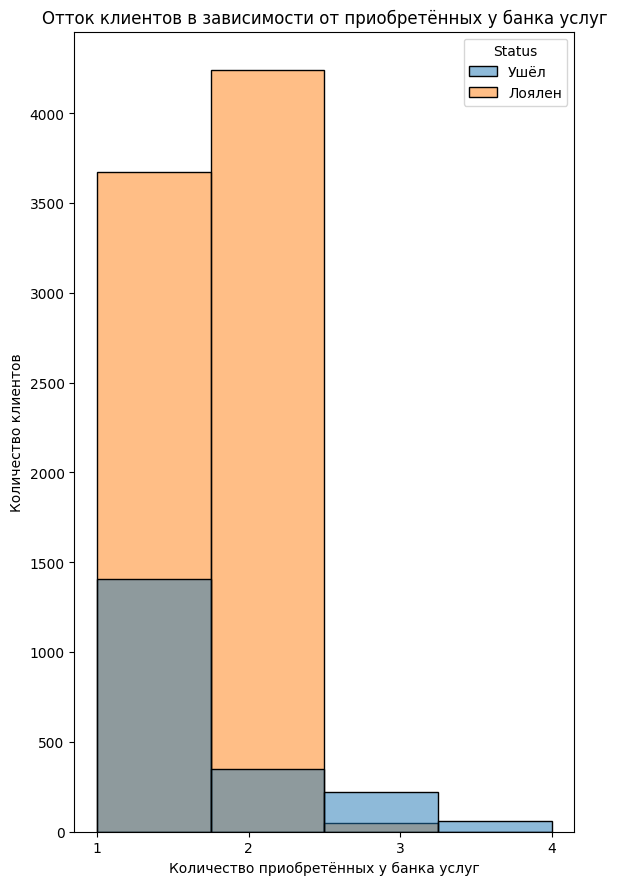

In [93]:
fig = plt.figure(figsize=(5, 8))
axes = fig.add_axes([0, 0, 1, 1])
sns.histplot( # Строим гистограмму
    data=ch_data,
    x='NumOfProducts',
    bins=4,
    hue='Status', # Добавляем уровень по признаку Status
)
axes.set_title('Отток клиентов в зависимости от приобретённых у банка услуг')
axes.set_xlabel('Количество приобретённых у банка услуг')
axes.set_ylabel('Количество клиентов')
axes.set_xticks([1, 2, 3, 4]); # Указываем метки оси X, чтобы не появились десятичные значения

Оценим активность лояльных и ушедших клиентов.

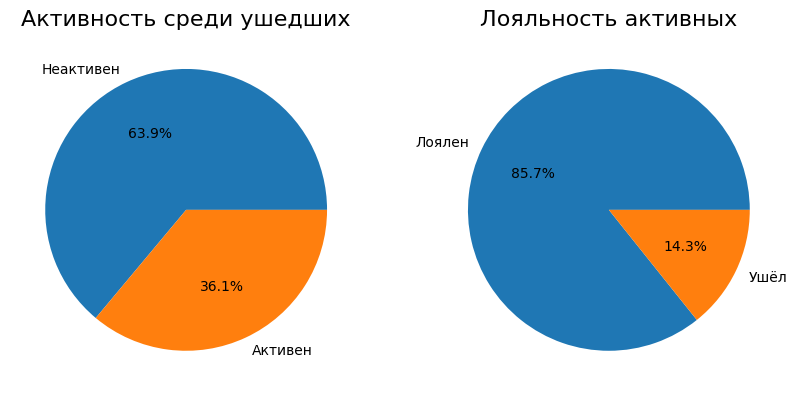

In [94]:
# Для более понятного отображения статуса активности введём новый признак Activity,
# который будет указывать активность клиента не в непонятных цифрах,
# а напрямую словами "Активный" и "Неактивный"
def get_activity(activity): # Создаём функцию, определяющую статус клиента
    if activity == 0:
        if_active = 'Неактивен'
    else:
        if_active = 'Активен'
    return if_active
if_act = ch_data['IsActiveMember'].apply(get_activity) # Распространяем функцию на таблицу
ch_data['Activity'] = if_act # Вводим в таблицу новый столбец
ch_data_exited['Activity'] = if_act # Такой же столбец вводим в уже имеющуюся таблицу ch_data_exited, где находятся только ушедшие клиенты

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 10)) # Создаём поле для двух диаграмм
active = ch_data_exited['Activity'].value_counts() # Создаём признак по активным и неактивным клиентам
axes[0].pie( # В первой координатной плоскости создаём первую диаграмму, отображающую активность среди ушедших клиентов
    active,
    labels = active.index,
    autopct='%.1f%%'    
)
axes[0].set_title('Активность среди ушедших', fontsize = 16)

ch_data_nactive = ch_data[ch_data['IsActiveMember'] == 1] # Создадим новую таблицу, где будут присутствовать только активные клиенты
exitement = ch_data_nactive['Status'].value_counts() # Создаём в новой таблице признак по ушедшим и лояльным клиентам
axes[1].pie( # Во второй координатной плоскости создадим вторую диаграмму, отображающую лояльность активных клиентов
    exitement,
    labels = exitement.index,
    autopct='%.1f%%'    
)
axes[1].set_title('Лояльность активных', fontsize = 16);


### Предобработка данных. 

Для начала расширим датасет с помощью методов Feature Engineering. Создадим следующие признаки:
* `BalanceSalaryRatio` — отношение баланса на счетах к заработной плате клиента;
* `TenureByAge` — отношение времени пользования услугами банка к возрасту клиента;
* `CreditScoreGivenAge` — отношение кредитного рейтинга к возрасту клиента.

Затем перекодируем оставшиеся текстовые категориальные признаки в числовые бинарные столбцы.

In [100]:
# Создаём признак BalanceSalaryRatio
churn_data['BalanceSalaryRatio'] = churn_data.apply(lambda row: row.Balance /
                                  row.EstimatedSalary, axis = 1)
# Создаём признак TenureByAge
churn_data['TenureByAge'] = churn_data.apply(lambda row: row.Tenure /
                                  row.Age, axis = 1)
# Создаём признак CreditScoreGivenAge
churn_data['CreditScoreGivenAge'] = churn_data.apply(lambda row: row.CreditScore /
                                  row.Age, axis = 1)
# Производим двоичное кодирование признака пола.
churn_data['Gender'] = churn_data['Gender'].apply(lambda x: 1 if x == 'Male' else 0)
# Выводим на экран основную статистическую информацию по новым признакам
churn_data[['BalanceSalaryRatio', 'TenureByAge', 'CreditScoreGivenAge']].describe()

,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge
count,2509.000000,2509.000000,2509.000000
mean,9.024870,0.134303,17.526487
std,214.286020,0.087680,5.349558
min,0.192582,0.000000,6.112676
25%,0.783284,0.060606,13.686275
50%,1.197220,0.125000,16.857143
75%,2.400083,0.200000,20.852941
max,10614.655440,0.500000,46.388889


Разделим исходный набор данных на матрицу наблюдений `X` (фичи) и столбец ответов `y` (таргет). 

In [101]:
X = churn_data.drop("Exited", axis=1)
y = churn_data["Exited"]

Посмотрим на сбалансированность данных. 

In [102]:
y.value_counts(normalize=True)

Exited
0    0.675568
1    0.324432
Name: proportion, dtype: float64

Очевидно, что классы не сбалансированы. Ушедших пользователей 32 %, в то время как лояльных — 68 %.


Выполним стратифицированное разделение на обучающую и тестовую выборки.

In [103]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, 
    stratify=y, 
    random_state=0
)
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (1881, 12)
Test shape: (628, 12)


Проверим, что число лояльных и ушедших клиентов примерно одинаково в каждой из выборок:

In [104]:
print('Train :')
display(y_train.value_counts(normalize=True))
print('\n')
print('Test :', )
display(y_test.value_counts(normalize=True))

Train :


Exited
0    0.675704
1    0.324296
Name: proportion, dtype: float64



Test :


Exited
0    0.675159
1    0.324841
Name: proportion, dtype: float64

Соотношения одинаковы, а значит, мы можем перейти к следующему шагу.

### Масштабирование данных.

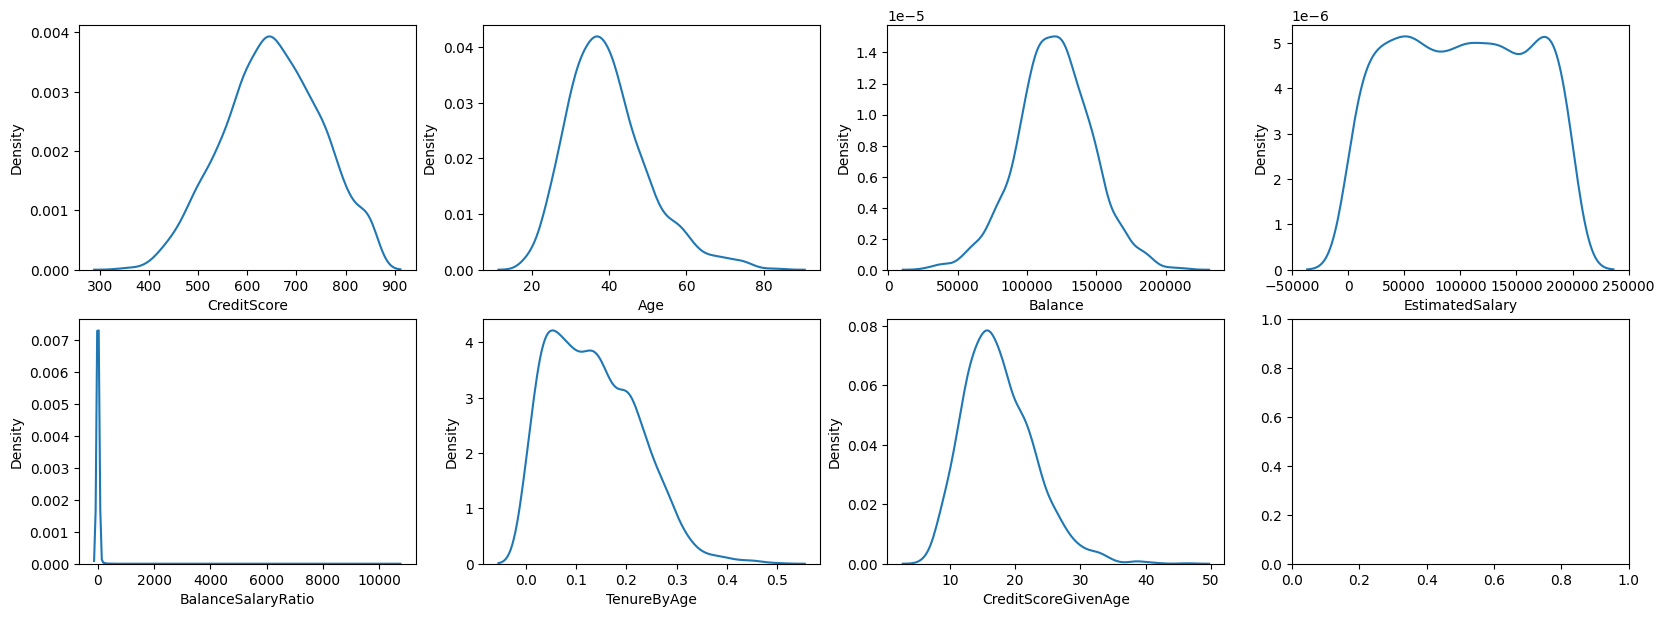

In [105]:
# Чтобы определиться с выбором принципа преобразования признаков,
# посмотрим на их распределение.
# Готовим координатную плоскость:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize = (20, 7))

# Посмотрим на графики распределения kde в числовых признаках:
ax1 = sns.kdeplot(X['CreditScore'], ax=axes[0,0])
ax2 = sns.kdeplot(X['Age'], ax=axes[0,1])
ax3 = sns.kdeplot(X['Balance'], ax=axes[0,2])
ax4 = sns.kdeplot(X['EstimatedSalary'], ax=axes[0,3])
ax5 = sns.kdeplot(X['BalanceSalaryRatio'], ax=axes[1,0])
ax6 = sns.kdeplot(X['TenureByAge'], ax=axes[1,1])
ax7 = sns.kdeplot(X['CreditScoreGivenAge'], ax=axes[1,2])

Как видно, не во всех признаках данные распределены нормально. Следовательно, необходимо выбрать нормализацию. Чтобы определиться с методом нормализации, посмотрим на выбросы в данных.

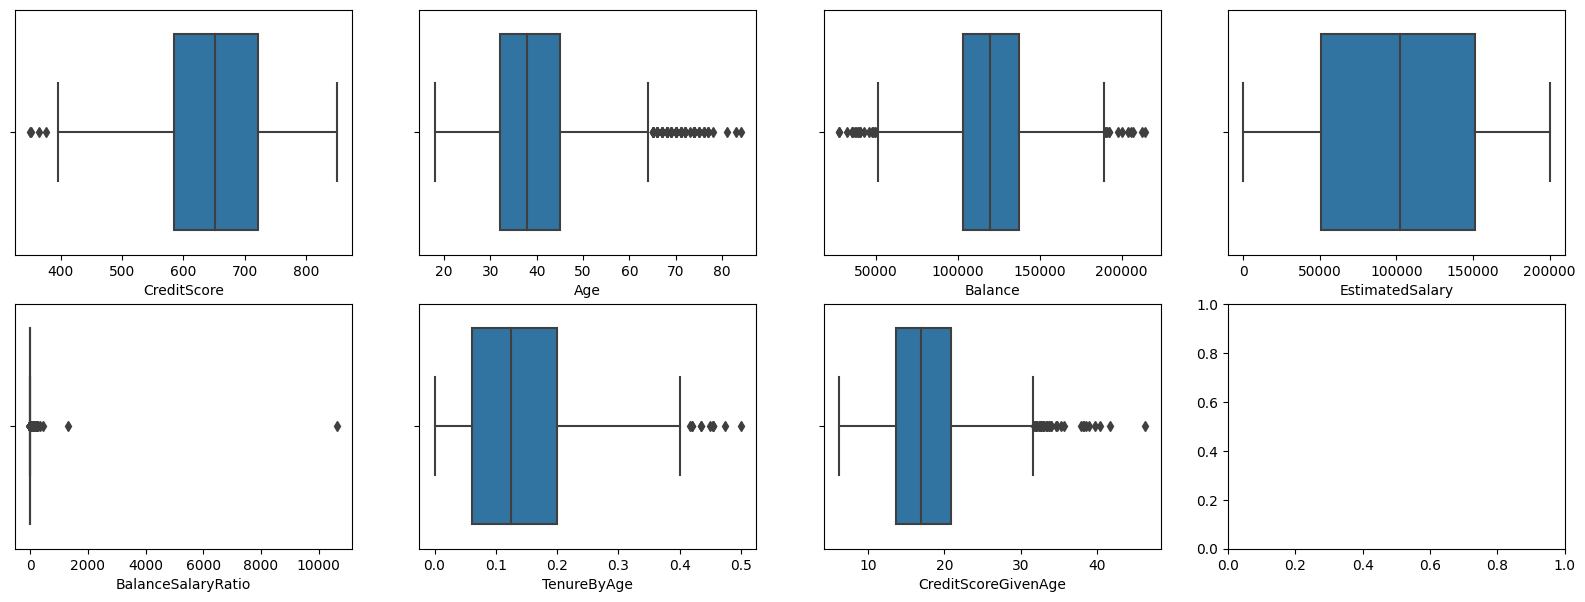

In [106]:
# Готовим координатную плоскость:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize = (20, 7))

# Построим коробчатые диаграммы признаков:
ax1 = sns.boxplot(data=X, x='CreditScore', ax=axes[0,0])
ax2 = sns.boxplot(data=X, x='Age', ax=axes[0,1])
ax3 = sns.boxplot(data=X, x='Balance', ax=axes[0,2])
ax4 = sns.boxplot(data=X, x='EstimatedSalary', ax=axes[0,3])
ax5 = sns.boxplot(data=X, x='BalanceSalaryRatio', ax=axes[1,0])
ax6 = sns.boxplot(data=X, x='TenureByAge', ax=axes[1,1])
ax7 = sns.boxplot(data=X, x='CreditScoreGivenAge', ax=axes[1,2])

Итак, выбросы в данных присутствуют. Значит, необходимо выбрать метод Roubustscaller

In [107]:
scaler = preprocessing.RobustScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

Теперь переходим к моделированию.

### Определение метрики качества.

Для начала давайте заранее определим метрику, на которую будем ориентироваться. 

По условию задачи, наша модель должна своевременно предсказывать отток клиентов. Известно, что для сохранения клиентов банк будет использовать ресурсы колл-центра, и клиентам, у которых вероятность оттока наиболее высока, будут сделаны специальные предложения. Ресурсы, выделяемые на сохранение клиентов, ограничены, поэтому нам важно минимизировать количество звонков. Однако в то же время необходимо сохранить как можно больше клиентов.

Таким образом, нам бы хотелось минимизировать как ложноположительные и ложноотрицательные срабатывания модели.

В данном случае необходимо использовать взвешенное среднее гармоническое между precision и recall, т.е. $F_1$-меру, т.к. именно она сводит к минимуму как ложноположительные. так и ложноотрицательные срабатывания.

### Построение модели.

Обучим модель логистической регрессии (`Logistic Regression`) на тренировочных данных. 

In [108]:
#Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(
    solver='sag', #алгоритм оптимизации
    random_state=42, #генератор случайных чисел
    max_iter=1000 #количество итераций на сходимость
)
#Обучаем модель, минимизируя logloss
log_reg.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000, random_state=42, solver='sag')

In [109]:
#Делаем предсказание для тренировочной выборки
y_train_pred = log_reg.predict(X_train_scaled)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_train, y_train_pred))
#Делаем предсказание для тестовой выборки
y_test_pred = log_reg.predict(X_test_scaled)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.70      0.94      0.80      1271
           1       0.55      0.14      0.23       610

    accuracy                           0.68      1881
   macro avg       0.62      0.54      0.51      1881
weighted avg       0.65      0.68      0.62      1881

              precision    recall  f1-score   support

           0       0.70      0.94      0.80       424
           1       0.55      0.15      0.24       204

    accuracy                           0.68       628
   macro avg       0.63      0.55      0.52       628
weighted avg       0.65      0.68      0.62       628



> Поскольку метрика F1 для класса "1" меньше 0,5, можно сделать вывод. что наша модель является недообученной.

Попробуем ввести штраф в нашу модель.

In [110]:
#Создаем объект класса логистическая регрессия
log_reg_penalty = linear_model.LogisticRegression(
    solver='sag', #алгоритм оптимизации
    random_state=42, #генератор случайных чисел
    max_iter=1000, #количество итераций на сходимость
    penalty = 'l2', # штраф
)
#Обучаем модель, минимизируя logloss
log_reg_penalty.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000, random_state=42, solver='sag')

In [111]:
#Делаем предсказание для тренировочной выборки
y_train_pred_penalty = log_reg_penalty.predict(X_train_scaled)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_train, y_train_pred_penalty))
#Делаем предсказание для тестовой выборки
y_test_pred_penalty = log_reg_penalty.predict(X_test_scaled)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_test, y_test_pred_penalty))

              precision    recall  f1-score   support

           0       0.70      0.94      0.80      1271
           1       0.55      0.14      0.23       610

    accuracy                           0.68      1881
   macro avg       0.62      0.54      0.51      1881
weighted avg       0.65      0.68      0.62      1881

              precision    recall  f1-score   support

           0       0.70      0.94      0.80       424
           1       0.55      0.15      0.24       204

    accuracy                           0.68       628
   macro avg       0.63      0.55      0.52       628
weighted avg       0.65      0.68      0.62       628



Результат не изменился. Попробуем установить параметр C на 0,1 при сохранении штрафа.

In [112]:
#Создаем объект класса логистическая регрессия
log_reg_penalty_С = linear_model.LogisticRegression(
    solver='sag', #алгоритм оптимизации
    random_state=42, #генератор случайных чисел
    max_iter=1000, #количество итераций на сходимость
    penalty = 'l2', # штраф
    C = 0.1 # Изменяем параметр С на 0,1 вместо 1 
)
#Обучаем модель, минимизируя logloss
log_reg_penalty_С.fit(X_train_scaled, y_train)

LogisticRegression(C=0.1, max_iter=1000, random_state=42, solver='sag')

In [113]:
#Делаем предсказание для тренировочной выборки
y_train_pred_penalty_С = log_reg_penalty_С.predict(X_train_scaled)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_train, y_train_pred_penalty_С))
#Делаем предсказание для тестовой выборки
y_test_pred_penalty_С = log_reg_penalty_С.predict(X_test_scaled)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_test, y_test_pred_penalty_С))

              precision    recall  f1-score   support

           0       0.70      0.94      0.80      1271
           1       0.55      0.14      0.23       610

    accuracy                           0.68      1881
   macro avg       0.62      0.54      0.51      1881
weighted avg       0.65      0.68      0.62      1881

              precision    recall  f1-score   support

           0       0.70      0.94      0.80       424
           1       0.55      0.15      0.24       204

    accuracy                           0.68       628
   macro avg       0.63      0.55      0.52       628
weighted avg       0.65      0.68      0.62       628



Ни одна из метрик не изменилась. Способы применения штрафа и изменения параметра С не дали результатов.

Сгенерируем полиномиальные признаки третьей степени для тренировочной и тестовой выборок. 

In [114]:
#Создаем объект для генерации полиномиальных признаков степени 3
poly = preprocessing.PolynomialFeatures(degree=3, include_bias=False)
#Вычисляем параметры генерации - результирующее количество признак
poly.fit(X_train_scaled)
#Производим преобразование для каждой из выборок
X_train_scaled_poly = poly.transform(X_train_scaled)
X_test_scaled_poly = poly.transform(X_test_scaled)

print('Train shape: {}'.format(X_train_scaled_poly.shape))
print('Test shape: {}'.format(X_test_scaled_poly.shape))

Train shape: (1881, 454)
Test shape: (628, 454)


In [115]:
#Создаем объект класса логистическая регрессия
log_reg_poly = linear_model.LogisticRegression(
    solver='sag', #алгоритм оптимизации
    random_state=42, #генератор случайных чисел
    max_iter=1000, #количество итераций на сходимость
)
#Обучаем модель, минимизируя logloss
log_reg_poly.fit(X_train_scaled_poly, y_train)

LogisticRegression(max_iter=1000, random_state=42, solver='sag')

In [116]:
#Делаем предсказание для тренировочной выборки
y_train_pred_poly = log_reg_poly.predict(X_train_scaled_poly)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_train, y_train_pred_poly))
#Делаем предсказание для тестовой выборки
y_test_pred_poly = log_reg_poly.predict(X_test_scaled_poly)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_test, y_test_pred_poly))

              precision    recall  f1-score   support

           0       0.69      0.52      0.59      1271
           1       0.34      0.51      0.41       610

    accuracy                           0.52      1881
   macro avg       0.51      0.51      0.50      1881
weighted avg       0.57      0.52      0.53      1881

              precision    recall  f1-score   support

           0       0.68      0.51      0.59       424
           1       0.33      0.50      0.40       204

    accuracy                           0.51       628
   macro avg       0.51      0.51      0.49       628
weighted avg       0.57      0.51      0.53       628



> Модель стала более сбалансированной, но всё равно её предсказательные возможности неудовлетворительны. Модель недообучена.

Попробуем ввести штраф в нашу модель.

In [117]:
#Создаем объект класса логистическая регрессия
log_reg_poly_penalty = linear_model.LogisticRegression(
    solver='sag', #алгоритм оптимизации
    random_state=42, #генератор случайных чисел
    max_iter=1000, #количество итераций на сходимость
    penalty = 'l2', # штраф
)
#Обучаем модель, минимизируя logloss
log_reg_poly_penalty.fit(X_train_scaled_poly, y_train)

LogisticRegression(max_iter=1000, random_state=42, solver='sag')

In [118]:
#Делаем предсказание для тренировочной выборки
y_train_pred_poly_penalty = log_reg_poly_penalty.predict(X_train_scaled_poly)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_train, y_train_pred_poly_penalty))
#Делаем предсказание для тестовой выборки
y_test_pred_poly_penalty = log_reg_poly_penalty.predict(X_test_scaled_poly)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_test, y_test_pred_poly_penalty))

              precision    recall  f1-score   support

           0       0.69      0.52      0.59      1271
           1       0.34      0.51      0.41       610

    accuracy                           0.52      1881
   macro avg       0.51      0.51      0.50      1881
weighted avg       0.57      0.52      0.53      1881

              precision    recall  f1-score   support

           0       0.68      0.51      0.59       424
           1       0.33      0.50      0.40       204

    accuracy                           0.51       628
   macro avg       0.51      0.51      0.49       628
weighted avg       0.57      0.51      0.53       628



Результат не изменился. Попробуем установить параметр C на 0,1 при сохранении штрафа.

In [119]:
#Создаем объект класса логистическая регрессия
log_reg_poly_penalty_С = linear_model.LogisticRegression(
    solver='sag', #алгоритм оптимизации
    random_state=42, #генератор случайных чисел
    max_iter=1000, #количество итераций на сходимость
    penalty = 'l2', # штраф
    C = 0.1 # Изменяем параметр С на 0,1 вместо 1 
)
#Обучаем модель, минимизируя logloss
log_reg_poly_penalty_С.fit(X_train_scaled_poly, y_train)

LogisticRegression(C=0.1, max_iter=1000, random_state=42, solver='sag')

In [120]:
#Делаем предсказание для тренировочной выборки
y_train_pred_poly_penalty_С = log_reg_poly_penalty_С.predict(X_train_scaled_poly)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_train, y_train_pred_poly_penalty_С))
#Делаем предсказание для тестовой выборки
y_test_pred_poly_penalty_С = log_reg_poly_penalty_С.predict(X_test_scaled_poly)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_test, y_test_pred_poly_penalty_С))

              precision    recall  f1-score   support

           0       0.69      0.52      0.59      1271
           1       0.34      0.51      0.41       610

    accuracy                           0.52      1881
   macro avg       0.51      0.51      0.50      1881
weighted avg       0.57      0.52      0.53      1881

              precision    recall  f1-score   support

           0       0.68      0.51      0.59       424
           1       0.33      0.50      0.40       204

    accuracy                           0.51       628
   macro avg       0.51      0.51      0.49       628
weighted avg       0.57      0.51      0.53       628



Ни одна из метрик не изменилась. Способы применения штрафа и изменения параметра С не дали результатов.

Попробуем подобрать значение порога вероятности, при котором наблюдается наибольшее значение целевой метрики на тестовой выборке. В качестве модели используем логистическую регрессию, обученную на полиномиальных признаках. 

В качестве порога вероятности используем значения из следующего диапазона:

`thresholds = np.arange(0.1, 1, 0.05)`

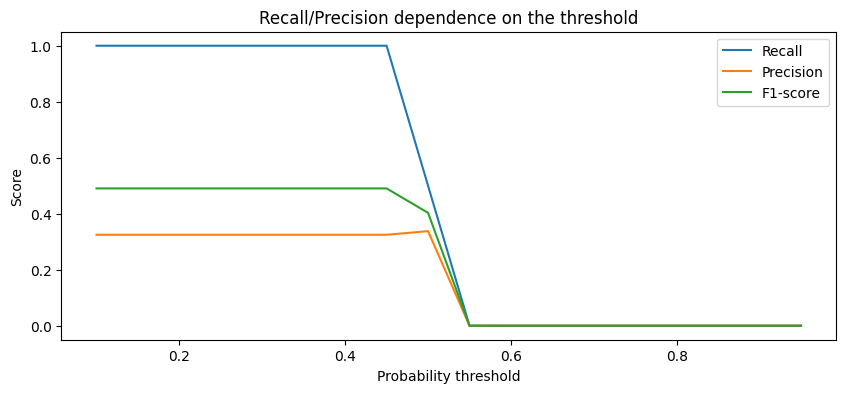

In [121]:
# Нас интересует только вероятность класса "1" (второй столбец)
y_test_proba_pred = log_reg_poly.predict_proba(X_test_scaled_poly)[:, 1]
#Для удобства завернем numpy-массив в pandas Series
y_test_proba_pred = pd.Series(y_test_proba_pred)
#Создадим списки, в которых будем хранить значения метрик 
recall_scores = []
precision_scores = []
f1_scores = []
#Сгенерируем набор вероятностных порогов в диапазоне от 0.1 до 1
thresholds = np.arange(0.1, 1, 0.05)
#В цикле будем перебирать сгенерированные пороги
for threshold in thresholds:
    # Если результат предсказания выше threshold, отнесём его к классу 1
    #В противном случае - к классу 0
    y_test_pred = y_test_proba_pred.apply(lambda x: 1 if x>threshold else 0)
    #Считаем метрики и добавляем их в списки
    recall_scores.append(metrics.recall_score(y_test, y_test_pred))
    precision_scores.append(metrics.precision_score(y_test, y_test_pred))
    f1_scores.append(metrics.f1_score(y_test, y_test_pred))

#Визуализируем метрики при различных threshold
fig, ax = plt.subplots(figsize=(10, 4)) #фигура + координатная плоскость
#Строим линейный график зависимости recall от threshold
ax.plot(thresholds, recall_scores, label='Recall')
#Строим линейный график зависимости precision от threshold
ax.plot(thresholds, precision_scores, label='Precision')

#Строим линейный график зависимости F1 от threshold
ax.plot(thresholds, f1_scores, label='F1-score')
#Даем графику название и подписи осям
ax.set_title('Recall/Precision dependence on the threshold')
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Score')
ax.legend();

Как видно из графика, наибольшие значения метрика F1 принимает на отрезке [0,1; 0,45]. Можно взять любое значение threshold на этом отрезке. Возьмём 0,45.

In [122]:
#Задаем оптимальный порог вероятностей
threshold_opt = 0.45
#Людей, у которых вероятность зарабатывать >50K больше 0.4 относим к классу 1
#В противном случае - к классу 0
y_test_pred_opt = y_test_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)
#Считаем метрики
print(metrics.classification_report(y_test, y_test_pred_opt))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       424
           1       0.32      1.00      0.49       204

    accuracy                           0.32       628
   macro avg       0.16      0.50      0.25       628
weighted avg       0.11      0.32      0.16       628



Наша модель стала безошибочно предсказывать всех ушедших клиентов (об этом говорит метрика recall), но метрика precision говорит нам, что примерно в двух случаях из трёх она делает ошибку I рода, т.е. причисляет к ушедшим лояльных клиентов, а это противоречит нашей задаче. Отсюда низкий показатель F1-метрики (0,49). Поэтому модель стоит признать неудовлетворительной.

## Деревья решений и случайный лес

In [ ]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, 
    stratify=y, 
    random_state=0
)
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (1881, 12)
Test shape: (628, 12)


In [123]:
from sklearn import tree
from sklearn import ensemble

In [124]:
#Создаем объект класса дерево решений
dt = tree.DecisionTreeClassifier(
    criterion='entropy',
    random_state=42
)
#Обучаем дерево по алгоритму CART
dt.fit(X_train, y_train)
#Выводим значения метрики 
y_train_pred = dt.predict(X_train)
print('Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = dt.predict(X_test)
print('Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Train: 1.00
Test: 0.57


> На тренировочной выборке наша модель не делает ошибок, но при вводе новых данных ошибается примерно в половине случаев. **Это явный признак переобученности**.

«Подстрижём» наше дерево. 

Обучим на тренировочной выборке дерево решений из библиотеки `sklearn` (`DecisionTreeClassifier`) с максимальной глубиной 8. В качестве критерия информативности используем энтропию Шеннона, минимальное число объектов в листе — 10.

In [125]:
#Создаем объект класса дерево решений
dt = tree.DecisionTreeClassifier(
    criterion='entropy',
    min_samples_leaf=5,
    max_depth=8,
    random_state=42
)
#Обучаем дерево по алгоритму CART
dt.fit(X_train, y_train)
#Выводим значения метрики 
y_train_pred = dt.predict(X_train)
print('Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = dt.predict(X_test)
print('Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Train: 0.73
Test: 0.62


> Модель стала работать лучше: метрика F1 на тренировочной модели снизилась, значит, пропала переобученность. Предсказания на тестовой выборке стали точнее, но всё же далеки от идеального.

Воспользуемся случайным лесом. 

Построим случайный лес (`RandomForestClassifier`) из 500 деревьев с максимальной глубиной 8. Критерий информативности — энтропия Шеннона, минимальное число объектов в листе — 10.

In [126]:
#Создаем объект класса случайный лес
rf = ensemble.RandomForestClassifier(
    n_estimators=500,
    max_depth=8,
    criterion='entropy',
    min_samples_leaf=10,
    random_state=42
)
#Обучаем модель
rf.fit(X_train, y_train)
#Выводим значения метрики 
y_train_pred = rf.predict(X_train)
print('Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = rf.predict(X_test)
print('Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Train: 0.74
Test: 0.66


> Модель стала работать немного лучше, хотя изменения и несущественны: всего пара сотых как на тренировочной, так и на тестовой выборках.

Попробуем подобрать значение порога вероятности, при котором наблюдается наибольшее значение целевой метрики на тестовой выборке. **Используем ту модель (из рассмотренных ранее), которая показала наилучшее качество на тестовой выборке.**


В качестве порога вероятности используем значения из следующего диапазона:

`thresholds = np.arange(0.1, 1, 0.05)`

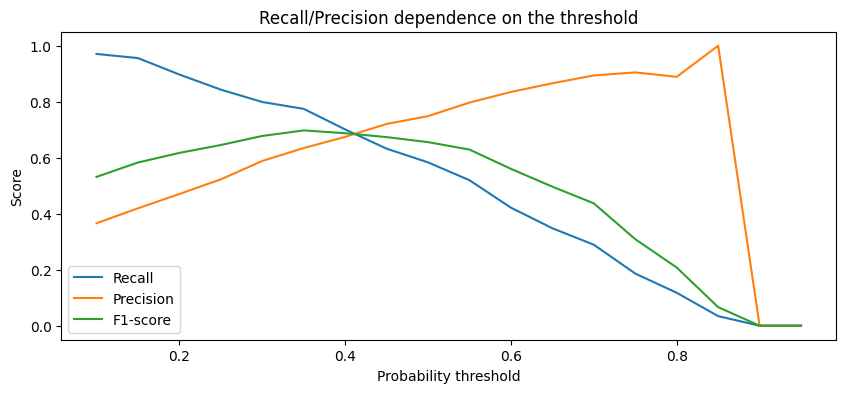

In [127]:
#Нас интересует только вероятность класса "1" (второй столбец)
y_test_proba_pred = rf.predict_proba(X_test)[:, 1]
#Для удобства завернем numpy-массив в pandas Series
y_test_proba_pred = pd.Series(y_test_proba_pred)
#Создадим списки, в которых будем хранить значения метрик 
recall_scores = []
precision_scores = []
f1_scores = []
#Сгенерируем набор вероятностных порогов в диапазоне от 0.1 до 1
thresholds = np.arange(0.1, 1, 0.05)
#В цикле будем перебирать сгенерированные пороги
for threshold in thresholds:
    # Если результат предсказания выше threshold, отнесём его к классу 1
    #В противном случае - к классу 0
    y_test_pred = y_test_proba_pred.apply(lambda x: 1 if x>threshold else 0)
    #Считаем метрики и добавляем их в списки
    recall_scores.append(metrics.recall_score(y_test, y_test_pred))
    precision_scores.append(metrics.precision_score(y_test, y_test_pred))
    f1_scores.append(metrics.f1_score(y_test, y_test_pred))

#Визуализируем метрики при различных threshold
fig, ax = plt.subplots(figsize=(10, 4)) #фигура + координатная плоскость
#Строим линейный график зависимости recall от threshold
ax.plot(thresholds, recall_scores, label='Recall')
#Строим линейный график зависимости precision от threshold
ax.plot(thresholds, precision_scores, label='Precision')

#Строим линейный график зависимости F1 от threshold
ax.plot(thresholds, f1_scores, label='F1-score')
#Даем графику название и подписи осям
ax.set_title('Recall/Precision dependence on the threshold')
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Score')
ax.legend();

> Как видно из графика, метрика F1 показывает наилучшие результаты при threshold = 0,35. Однако при threshold = 0,4 все метрики равны. Будем считать это значение оптимальным.

In [128]:
#Задаем оптимальный порог вероятностей
threshold_opt = 0.4
#Клиенты, у которых вероятность вероятность покинуть банк больше 0.4, относим к классу 1
#В противном случае - к классу 0
y_test_pred_opt = y_test_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)
#Считаем метрики
print(metrics.classification_report(y_test, y_test_pred_opt))

              precision    recall  f1-score   support

           0       0.85      0.84      0.85       424
           1       0.67      0.70      0.69       204

    accuracy                           0.79       628
   macro avg       0.76      0.77      0.77       628
weighted avg       0.80      0.79      0.79       628



Мы оказались правы. Метрика F1, пусть и незначительно, но улучшилась.

**Цель проекта достигнута**